In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from utils import functions_3D as F3D
import matplotlib.pyplot as plt
plt.style.use(r'utils/mplstyle')

from matplotlib import gridspec
import quaternion

# generate a 2-sphere for plotting

THETA = np.linspace(1e-4, np.pi - 1e-4, 200)
PHI = np.linspace(0, np.pi * 2, 200)

THETA, PHI = np.meshgrid(THETA, PHI)

X = np.sin(THETA) * np.cos(PHI)
Y = np.sin(THETA) * np.sin(PHI)
Z = np.cos(THETA)

In [2]:
# nice colours to use

colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fb9d32', '#fec787']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = [colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange]

In [3]:
seed = 219
std = 0.25
maxL = 5 # l = 2, ..., maxL

alpha = 0.150
f = np.sin(alpha)
g = np.cos(alpha)

np.random.seed(seed)
As = np.random.normal(0, std, (maxL + 1) ** 2 - 1 - 3) # * np.array([0, 1, 1, 0, 0])
Ps = np.random.random(len(As)) * np.pi * 2

ball = F3D.ball(maxL, As, Ps)

In [4]:
# check the curvature across the ball
ball.check_kappa(grid_point = 100)

Maximum and minimum curvatures are: 1.66 and 0.33. These will be used to set upper and lower bounds on cmaps


In [5]:
# render the ball info, to be used for draw_ball etc.
ball.make_ball(grid_point = 200, keep = True);

In [6]:
# print critical ramp angle
QStar = np.max(ball.QFact)
alphaStar = np.arctan(QStar)
print(alphaStar)

0.1387067484434942


In [7]:
# m = 0
m = 0
T_interval = 50
N_interval = 4

STA_M0 = []
INI_M0 = np.array([[1.78, -1.00, 4.5], [1.17, 2.96, -2.459]])

for ini_con in INI_M0:
    _sful = []
    ball.initialisation_simple(THETA_CT = ini_con[0], PHI_CT = ini_con[1], spin = ini_con[2])

    for i in range(N_interval):
        ball.simulate(f = f, g = g, ti = 0, tf = T_interval, outputN = 1000)
        if i > N_interval - 3: # keep only the last 100 time units, discard the others
            _sful.append(ball.s[1:])
            
        qA = ball.compute_direct_Q(ball.get_inputs(ball.s[-1, 0], ball.s[-1, 1]))
        qB = np.quaternion(*ball.s[-1, 2 : 6])
        qC0 = quaternion.as_float_array(qB * qA.conjugate())[0]
        qC3 = np.clip(quaternion.as_float_array(qB * qA.conjugate())[3], -1, 1)
        if qC0 > 0:
            spin = np.arcsin(qC3) * 2    
        else:
            if qC3 > 0:
                spin = (np.pi - np.arcsin(qC3)) * 2
            else:
                spin = (- np.pi - np.arcsin(qC3)) * 2
        ball.initialisation(THETA_CT = ball.s[-1, 0], PHI_CT = ball.s[-1, 1], spin = spin)
        
    _sful = np.vstack(_sful)
    # _qful *= np.sign(_qful)[:, 0][:, np.newaxis] # pull all q to have a positive scalar part
    
    STA_M0.append(_sful)

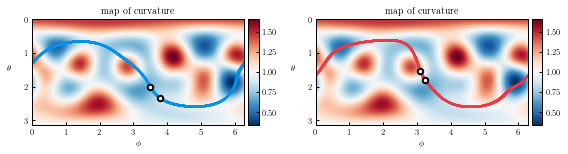

In [8]:
# visualise the motion of the contact point

fig, axes = plt.subplots(1, 2, figsize = (8, 2))
for i in range(2):
    ball.draw_kappa(axes[i])
    axes[i].scatter(STA_M0[i][:, 1] % (2 * np.pi), STA_M0[i][:, 0] % (np.pi), s = 1, c = colors[i][1])
    axes[i].scatter([STA_M0[i][0, 1] % (2 * np.pi), STA_M0[i][-1, 1] % (2 * np.pi)],
               [STA_M0[i][0, 0] % (np.pi), STA_M0[i][-1, 0] % (np.pi)],
               s = 30, facecolor = 'white', edgecolor = 'black', lw = 2)
    axes[i].set_xlabel(r'$\phi$')
    axes[i].set_ylabel(r'$\theta$', rotation = 0, labelpad = 15)
plt.tight_layout()
plt.savefig('3DPlots/inertial_doubling_contact_m{0}.pdf'.format(m))

In [9]:
# m = 6

# note: when the mass is very small, the orbit does not seem to split immediately
# this could mean there is another period-1 to period-2 phase transition
# governed by some other stability condition
# which is still a mystery to me - dq219

m = 6

T_interval = 50
N_interval = 8

STA_M1 = []
INI_M1 = np.array([[2.24, 3.98, 0.052, -0.027, 0.15, -0.009], [1.8, 3.648, 3.48, 0.033, 0.16, 0.011]])

for ini_con in INI_M1:
    _sful = []
    ball.initialisation_simple(THETA_CT = ini_con[0], PHI_CT = ini_con[1], spin = ini_con[2], inertia = True, DomegaDt = ini_con[3:6])

    for i in range(N_interval):
        ball.simulate(f = f, g = g, ti = 0, tf = T_interval, outputN = 1000, m = m)
        if i > N_interval - 3: # keep only the last 100 time units, discard the others
            _sful.append(ball.s[1:])
            
        qA = ball.compute_direct_Q(ball.get_inputs(ball.s[-1, 0], ball.s[-1, 1]))
        qB = np.quaternion(*ball.s[-1, 2 : 6])
        qC0 = quaternion.as_float_array(qB * qA.conjugate())[0]
        qC3 = np.clip(quaternion.as_float_array(qB * qA.conjugate())[3], -1, 1)
        if qC0 > 0:
            spin = np.arcsin(qC3) * 2    
        else:
            if qC3 > 0:
                spin = (np.pi - np.arcsin(qC3)) * 2
            else:
                spin = (- np.pi - np.arcsin(qC3)) * 2
        ball.initialisation(THETA_CT = ball.s[-1, 0], PHI_CT = ball.s[-1, 1], spin = spin, DomegaDt = ball.s[-1, 9:12], inertia = True)
        # if i == N_interval - 1:
        #     print([ball.s[-1, 0], ball.s[-1, 1], spin, *ball.s[-1, 9:12]])
    _sful = np.vstack(_sful)
    # _qful *= np.sign(_qful)[:, 0][:, np.newaxis] # pull all q to have a positive scalar part
    
    STA_M1.append(_sful)

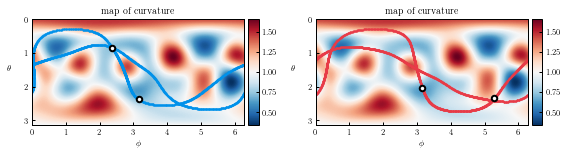

In [10]:
# visualise the motion of the contact point

fig, axes = plt.subplots(1, 2, figsize = (8, 2))
for i in range(2):
    ball.draw_kappa(axes[i])
    axes[i].scatter(STA_M1[i][:, 1] % (2 * np.pi), STA_M1[i][:, 0] % (np.pi), s = 1, c = colors[i][1])
    axes[i].scatter([STA_M1[i][0, 1] % (2 * np.pi), STA_M1[i][-1, 1] % (2 * np.pi)],
               [STA_M1[i][0, 0] % (np.pi), STA_M1[i][-1, 0] % (np.pi)],
               s = 30, facecolor = 'white', edgecolor = 'black', lw = 2)
    axes[i].set_xlabel(r'$\phi$')
    axes[i].set_ylabel(r'$\theta$', rotation = 0, labelpad = 15)
plt.tight_layout()

plt.savefig('3DPlots/inertial_doubling_contact_m{0}.pdf'.format(m))

In [11]:
# m = 10

m = 10

T_interval = 50
N_interval = 8

STA_M2 = []
INI_M2 = np.array([[2.19, 62.2, 6.14, -0.017, 0.15, -0.0038], [0.875, -54.15, -1.63, 0.00305, 0.146, -0.000561]])

for ini_con in INI_M1:
    _sful = []
    ball.initialisation_simple(THETA_CT = ini_con[0], PHI_CT = ini_con[1], spin = ini_con[2], inertia = True, DomegaDt = ini_con[3:6])

    for i in range(N_interval):
        ball.simulate(f = f, g = g, ti = 0, tf = T_interval, outputN = 1000, m = m)
        if i > N_interval - 3: # keep only the last 100 time units, discard the others
            _sful.append(ball.s[1:])
            
        qA = ball.compute_direct_Q(ball.get_inputs(ball.s[-1, 0], ball.s[-1, 1]))
        qB = np.quaternion(*ball.s[-1, 2 : 6])
        qC0 = quaternion.as_float_array(qB * qA.conjugate())[0]
        qC3 = np.clip(quaternion.as_float_array(qB * qA.conjugate())[3], -1, 1)
        if qC0 > 0:
            spin = np.arcsin(qC3) * 2    
        else:
            if qC3 > 0:
                spin = (np.pi - np.arcsin(qC3)) * 2
            else:
                spin = (- np.pi - np.arcsin(qC3)) * 2
        ball.initialisation(THETA_CT = ball.s[-1, 0], PHI_CT = ball.s[-1, 1], spin = spin, DomegaDt = ball.s[-1, 9:12], inertia = True)
        # if i == N_interval - 1:
        #     print([ball.s[-1, 0], ball.s[-1, 1], spin, *ball.s[-1, 9:12]])
    _sful = np.vstack(_sful)
    # _qful *= np.sign(_qful)[:, 0][:, np.newaxis] # pull all q to have a positive scalar part
    
    STA_M2.append(_sful)

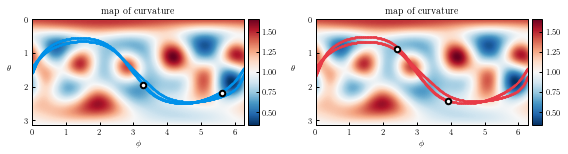

In [12]:
# visualise the motion of the contact point

fig, axes = plt.subplots(1, 2, figsize = (8, 2))
for i in range(2):
    ball.draw_kappa(axes[i])
    axes[i].scatter(STA_M2[i][:, 1] % (2 * np.pi), STA_M2[i][:, 0] % (np.pi), s = 1, c = colors[i][1])
    axes[i].scatter([STA_M2[i][0, 1] % (2 * np.pi), STA_M2[i][-1, 1] % (2 * np.pi)],
               [STA_M2[i][0, 0] % (np.pi), STA_M2[i][-1, 0] % (np.pi)],
               s = 30, facecolor = 'white', edgecolor = 'black', lw = 2)
    axes[i].set_xlabel(r'$\phi$')
    axes[i].set_ylabel(r'$\theta$', rotation = 0, labelpad = 15)
plt.tight_layout()
plt.savefig('3DPlots/inertial_doubling_contact_m{0}.pdf'.format(m))

In [13]:
# calculate the angular velocity of the m0 case
# code taken from the propagate_viscous method

M0_OMG = []
for i in range(2):
    _m0_omg = []
    for j in range(len(STA_M0[0])):
        [_t, _p] = STA_M0[i][j][:2]
        _inputs = ball.get_inputs(_t, _p)
        _x0 = F3D.x0_expression(*_inputs)
        _y0 = F3D.y0_expression(*_inputs)
        _z0 = F3D.z0_expression(*_inputs)
        omg_inputs = [*STA_M0[i][j][2:6], _x0, _y0, _z0, f, g]
        _m0_omg.append([F3D.omgx_expression(*omg_inputs),
                        F3D.omgy_expression(*omg_inputs),
                        F3D.omgz_expression(*omg_inputs)])
    M0_OMG.append(_m0_omg)

In [14]:
STA_M0 = np.dstack((STA_M0, M0_OMG))

In [15]:
STA_MS = np.array([STA_M0, STA_M1, STA_M2])

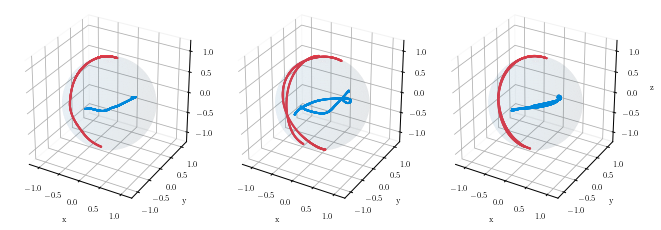

In [16]:
# visualise period-doubling in quaternion space

fig, axes = plt.subplots(1, 3, figsize = (9, 3), subplot_kw={'projection': '3d'})



for i in range(3):
    axes[i].set_box_aspect((1,1,1))
    axes[i].set_xlim(-1.2, 1.2)
    axes[i].set_ylim(-1.2, 1.2)
    axes[i].set_zlim(-1.2, 1.2)

    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_zlabel('z')
    axes[i].xaxis.pane.fill = False
    axes[i].yaxis.pane.fill = False
    axes[i].zaxis.pane.fill = False
    
    axes[i].plot_surface(X, Y, Z, alpha = 0.05, zorder = -100)
    
    for j in range(2):
        _q = STA_MS[i, j, :, 2 : 6]
        _q *= np.sign(_q)[:, 0][:, np.newaxis]
        axes[i].scatter(_q[:, 1], _q[:, 2], _q[:, 3], color = colors[j][1], s = 1)
plt.tight_layout()
plt.savefig('3DPlots/inertial_doubling_quaternions.pdf')

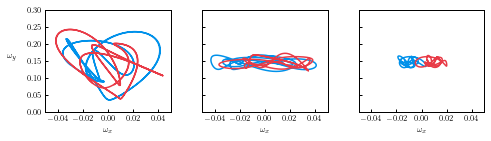

In [17]:
# visualise period-doubling in angular velocity

fig, axes = plt.subplots(1, 3, figsize = (7, 2), sharex = True, sharey = True)

for i in range(3):
    for j in range(2):
        _omg = STA_MS[i, j, :, 9 : 12]
        axes[i].plot(_omg[:, 0], _omg[:, 1], color = colors[j][1])
    axes[i].set_xlabel(r'$\omega_{x}$')
axes[0].set_ylabel(r'$\omega_{y}$', rotation = 0, labelpad = 15)
axes[0].set_xlim(-0.05, 0.05)
axes[0].set_ylim(0, 0.3)
plt.tight_layout()
plt.savefig('3DPlots/inertial_doubling_omegas.pdf')

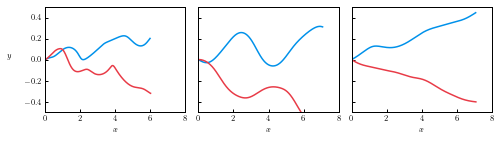

In [20]:
# visualise period-doubling in angular velocity

fig, axes = plt.subplots(1, 3, figsize = (7, 2), sharex = True, sharey = True)

for i in range(3):
    for j in range(2):
        _xyz = STA_MS[i, j, :, 6 : 8]
        _x = _xyz[999:, 0] # take the last interval
        _y = _xyz[999:, 1] # take the last interval
        _x = _x - _x[0]
        _y = _y - _y[0]
        axes[i].plot(_x, _y, color = colors[j][1])
    axes[i].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$y$', rotation = 0, labelpad = 15)
axes[0].set_xlim(0, 8)
axes[0].set_ylim(-0.5, 0.5)
plt.tight_layout()
plt.savefig('3DPlots/inertial_doubling_xy.pdf')